<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/GGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

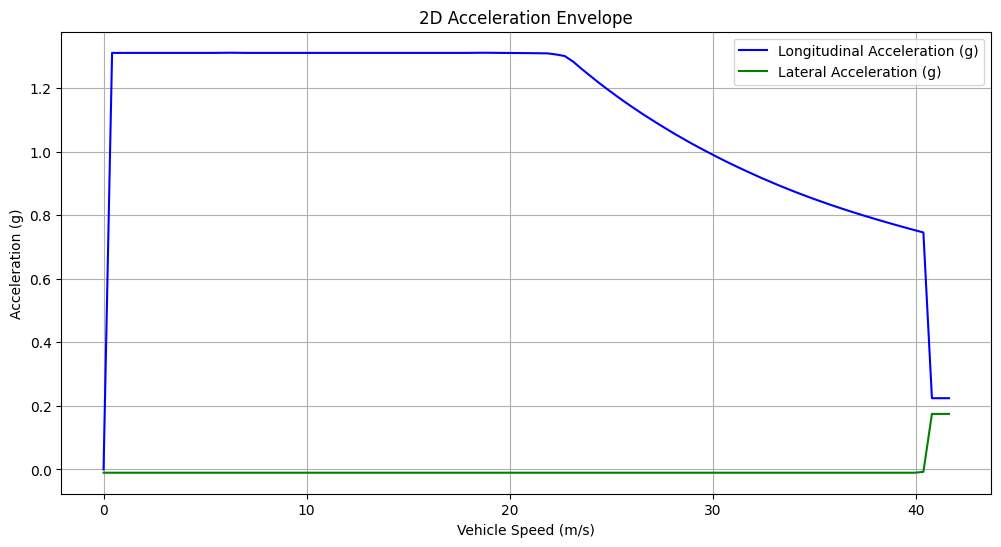

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constants
vehicle_mass_kg = 241  # Vehicle mass in kg
g = 9.81  # Acceleration due to gravity in m/s^2
tire_radius_m = 0.2629  # Tire radius in meters for Hoosier R25B 20.5 x 7.0-13
gear_ratio = 3.54  # Gear ratio from your Python code

# Load the datasets
tire_data = pd.read_csv('B1320run125.csv', skiprows=[1])
motor_data = pd.read_csv('MotorPower.csv')

# Create interpolation functions for torque and power
torque_interp = interp1d(motor_data['Motor Speed (RPM)'], motor_data['Torque (Capped at 80kW) (Nm)'],
                         bounds_error=False, fill_value="extrapolate")
power_interp = interp1d(motor_data['Motor Speed (RPM)'],
                        motor_data['Torque (Capped at 80kW) (Nm)'] * motor_data['Motor Speed (RPM)'] * 2 * np.pi / 60,
                        bounds_error=False, fill_value="extrapolate")

# Prepare arrays to hold acceleration values
speed_range = np.linspace(0, tire_data['V'].max(), 100)  # Speed range from tire data
long_acc = np.zeros_like(speed_range)
lat_acc = np.zeros_like(speed_range)

# Calculate the traction force available at each speed point
for i, speed in enumerate(speed_range):
    engine_rpm = speed / (2 * np.pi * tire_radius_m) * 60 * gear_ratio
    if engine_rpm >= motor_data['Motor Speed (RPM)'].min() and engine_rpm <= motor_data['Motor Speed (RPM)'].max():
        engine_torque = torque_interp(engine_rpm)
        wheel_torque = engine_torque * gear_ratio
        traction_force = wheel_torque / tire_radius_m
        long_acc[i] = traction_force / vehicle_mass_kg / g

    # Interpolating lateral force data
    lat_force = np.interp(speed, tire_data['V'], tire_data['FY'])
    lat_acc[i] = lat_force / vehicle_mass_kg / g

# Normalize long_acc within the bounds of tire data
max_long_force = np.interp(speed_range, tire_data['V'], tire_data['FX'])
max_long_acc = max_long_force / vehicle_mass_kg / g
long_acc = np.clip(long_acc, -max_long_acc, max_long_acc)

# 2D plot for lateral and longitudinal acceleration
plt.figure(figsize=(12, 6))
plt.plot(speed_range, long_acc, label='Longitudinal Acceleration (g)', color='blue')
plt.plot(speed_range, lat_acc, label='Lateral Acceleration (g)', color='green')
plt.title('2D Acceleration Envelope')
plt.xlabel('Vehicle Speed (m/s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()


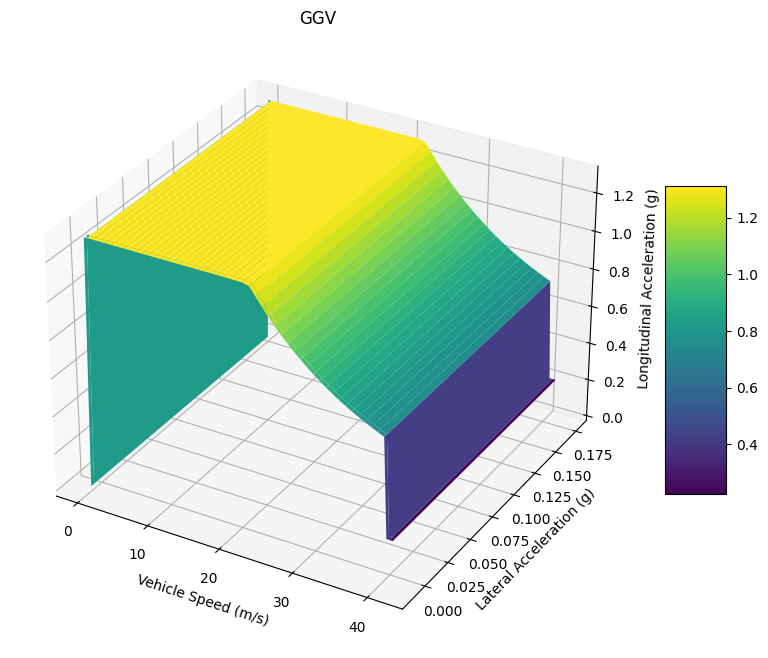

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Your existing code to calculate long_acc and lat_acc here...

# Create meshgrid for 3D plot
speed_mesh, lat_acc_mesh = np.meshgrid(speed_range, lat_acc)
_, long_acc_mesh = np.meshgrid(speed_range, long_acc)

# Since we only have a single line for lateral and longitudinal acceleration, we need to expand it
# to create a surface. Here we assume that the lateral and longitudinal acceleration are independent.
# This might not be realistic as in real scenarios, they are often dependent on each other and you
# would need actual combined data points for correct visualization.

# For visualization purposes, we just repeat the lat_acc and long_acc arrays
lat_acc_expanded = np.tile(lat_acc, (len(speed_range), 1)).T
long_acc_expanded = np.tile(long_acc, (len(lat_acc), 1))

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(speed_mesh, lat_acc_expanded, long_acc_expanded, cmap='viridis')

# Add labels and title
ax.set_xlabel('Vehicle Speed (m/s)')
ax.set_ylabel('Lateral Acceleration (g)')
ax.set_zlabel('Longitudinal Acceleration (g)')
ax.set_title('GGV')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [ ]:
""